<a href="https://colab.research.google.com/github/California3/super-resolution-resize-cv/blob/main/super_resolution_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Key Settings

In [ ]:
FORCE_UPGRADE = True

# Import Libraires

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Sep 19 06:31:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    41W / 300W |  13474MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
!pwd

/content


In [ ]:
!pip install chainer

In [ ]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.models import Sequential
from keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

from chainer import Chain
from chainer import functions as F
from chainer import links as L

# Copy Data To Local

In [ ]:
parents_loc = "/content/drive/MyDrive/ADV_CV_Code/"
native_loc = "/content/native/"
data_loc = native_loc + 'Dataset/Raw Data/'

# if native_loc exists, then we are running on a local machine
if os.path.exists(native_loc):
    print("Native location exists")
else:
    # create native_loc
    os.mkdir(native_loc)
    # copy all files from parents_loc to native_loc
    !cp -r $parents_loc* $native_loc
    print("Copied files from parents_loc to native_loc")

Native location exists


# Load Data

In [ ]:
# to get the files in proper order
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 256
high_img = []
low_img = []

path = data_loc + 'high_res'
path_low = data_loc + 'low_res'

files = os.listdir(path)
files = sorted_alphanumeric(files)

files_low = os.listdir(path_low)
files_low = sorted_alphanumeric(files_low)
for i in tqdm(files):
    if i == '855.jpg':
        break
    elif i in files_low:
        img = cv2.imread(path + '/'+i,1)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        high_img.append(img_to_array(img))

        img = cv2.imread(path_low + '/'+i,1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        low_img.append(img_to_array(img))

100%|██████████| 855/855 [00:06<00:00, 134.13it/s]


# Data Visualization

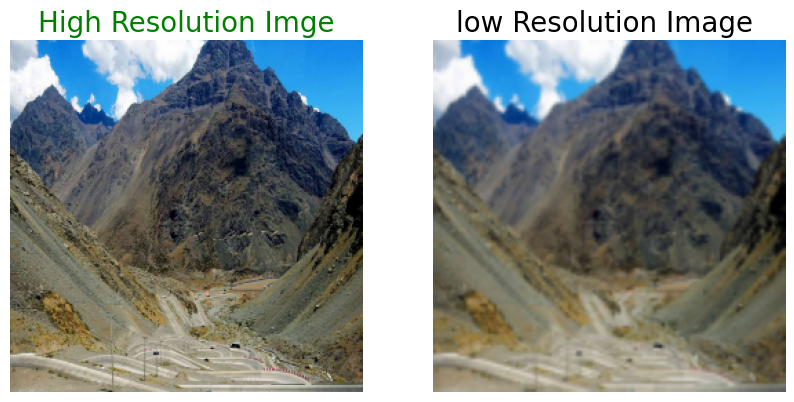

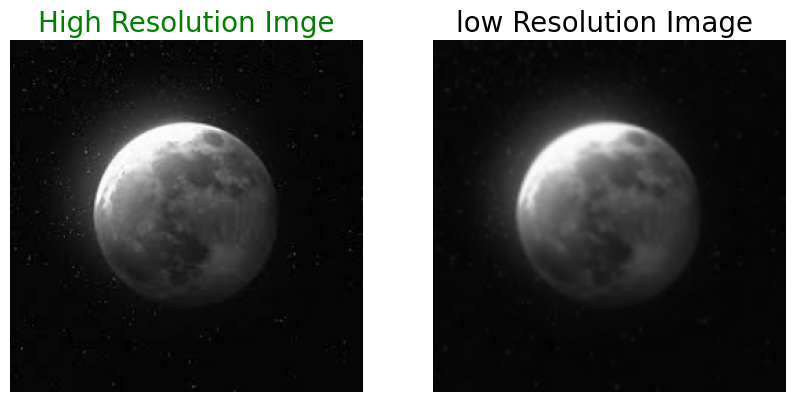

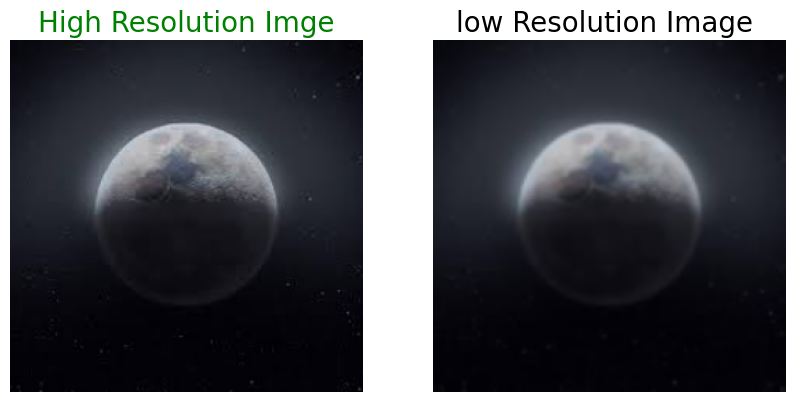

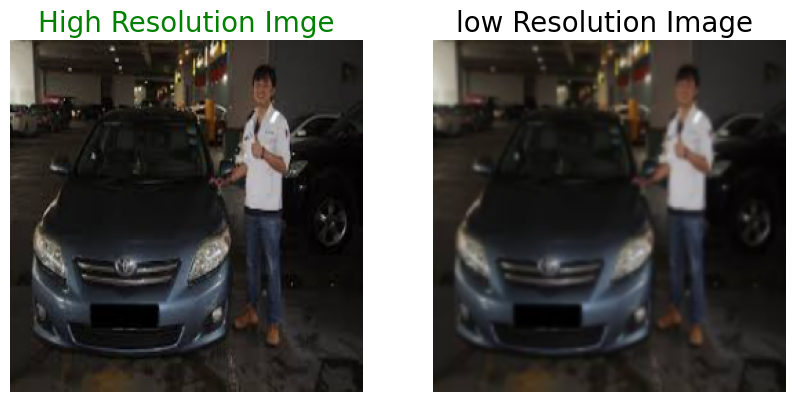

In [ ]:
for i in range(4):
    a = np.random.randint(0,855)
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.title('High Resolution Imge', color = 'green', fontsize = 20)
    plt.imshow(high_img[a])
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title('low Resolution Image ', color = 'black', fontsize = 20)
    plt.imshow(low_img[a])
    plt.axis('off')

# Slicing and Reshaping Images

In [ ]:
train_high_image = high_img[:700]
train_low_image = low_img[:700]
train_high_image = np.reshape(train_high_image,(len(train_high_image),SIZE,SIZE,3))
train_low_image = np.reshape(train_low_image,(len(train_low_image),SIZE,SIZE,3))

validation_high_image = high_img[700:830]
validation_low_image = low_img[700:830]
validation_high_image= np.reshape(validation_high_image,(len(validation_high_image),SIZE,SIZE,3))
validation_low_image = np.reshape(validation_low_image,(len(validation_low_image),SIZE,SIZE,3))


test_high_image = high_img[830:]
test_low_image = low_img[830:]
test_high_image= np.reshape(test_high_image,(len(test_high_image),SIZE,SIZE,3))
test_low_image = np.reshape(test_low_image,(len(test_low_image),SIZE,SIZE,3))

print("Shape of training images:",train_high_image.shape)
print("Shape of test images:",test_high_image.shape)
print("Shape of validation images:",validation_high_image.shape)


Shape of training images: (700, 256, 256, 3)
Shape of test images: (25, 256, 256, 3)
Shape of validation images: (130, 256, 256, 3)


# Defining Model

In [ ]:
from keras import layers
# Keep default functions.
def down_default(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample

def up_default(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample

# Our new functions.
def up_resize_conv(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()

    upsample.add(layers.UpSampling2D(size=(2, 2), data_format=None, interpolation='nearest'))
    upsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))

    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample

def down_upgrade(filters , kernel_size, apply_batch_normalization = True):
    return down_default(filters , kernel_size, apply_batch_normalization)

# New Interface For model
def upgrade(type = ""):
    upsample = tf.keras.models.Sequential()
    if type == "upgrade" or FORCE_UPGRADE:
        pass
    else:
        pass
    return upsample

def up(filters, kernel_size, dropout = False, type = ''):
    if type == 'resize_conv' or FORCE_UPGRADE:
        return up_resize_conv(filters, kernel_size, dropout)
    else:
        return up_default(filters, kernel_size, dropout)

def down(filters , kernel_size, apply_batch_normalization = True, type = ""):
    if type == "upgrade" or FORCE_UPGRADE:
        return down_upgrade(filters , kernel_size, apply_batch_normalization)
    else:
        return down_default(filters , kernel_size, apply_batch_normalization)

def model():
    inputs = layers.Input(shape= [SIZE,SIZE,3])
    # convolutions down the stack
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(512,(3,3),True)(d3)
    d5 = down(512,(3,3),True)(d4)

    # deconvolutions up the stack OR first upsampling then convolutions
    u1 = up(512,(3,3),False)(d5)
    d4_ = upgrade()(d4)
    u1 = layers.concatenate([u1,d4_])
    u2 = up(256,(3,3),False)(u1)
    d3_ = upgrade()(d3)
    u2 = layers.concatenate([u2,d3_])
    u3 = up(128,(3,3),False)(u2)
    d2_ = upgrade()(d2)
    u3 = layers.concatenate([u3,d2_])
    u4 = up(128,(3,3),False)(u3)
    d1_ = upgrade()(d1)
    u4 = layers.concatenate([u4,d1_])
    u5 = up(3,(3,3),False)(u4)
    inputs_ = upgrade()(inputs)
    u5 = layers.concatenate([u5,inputs_])
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)

model = model()
model.summary()

NameError: ignored

# Defining Model For Future
If time permit...

In [ ]:
# GAN Model
class Generator(Chain):
    def __init__(self):
        super().__init__(
            fc=L.Linear(None, 256*2*2),
            dc1=L.Deconvolution2D(256, 128, 4, stride=2, pad=1),
            dc2=L.Deconvolution2D(128, 64, 4, stride=2, pad=1),
            dc3=L.Deconvolution2D(64, 32, 4, stride=2, pad=1),
            dc4=L.Deconvolution2D(32, 3, 4, stride=2, pad=1),
            bn0=L.BatchNormalization(256*2*2),
            bn1=L.BatchNormalization(128),
            bn2=L.BatchNormalization(64),
            bn3=L.BatchNormalization(32)
        )

    def __call__(self, z, test=False):
        h = F.relu(self.bn0(self.fc(z), test=test))
        h = F.reshape(h, (z.shape[0], 256, 2, 2))

        h = F.relu(self.bn1(self.dc1(h), test=test))

        h = F.relu(self.bn2(self.dc2(h), test=test))

        h = F.relu(self.bn3(self.dc3(h), test=test))

        h = F.sigmoid(self.dc4(h))

        return h


class GeneratorResizeConvolution(Chain):
    def __init__(self):
        super().__init__(
            fc=L.Linear(None, 256*2*2),
            c1=L.Convolution2D(256, 128, 3, stride=1, pad=1),
            c2=L.Convolution2D(128, 64, 3, stride=1, pad=1),
            c3=L.Convolution2D(64, 32, 3, stride=1, pad=1),
            c4=L.Convolution2D(32, 3, 3, stride=1, pad=1),
            bn0=L.BatchNormalization(256*2*2),
            bn1=L.BatchNormalization(128),
            bn2=L.BatchNormalization(64),
            bn3=L.BatchNormalization(32)
        )

    def __call__(self, z, test=False):
        h = F.relu(self.bn0(self.fc(z), test=test))
        h = F.reshape(h, (z.shape[0], 256, 2, 2))

        # Upsample the image and then apply a dimension preserving convolution
        # with a kernel of size (3, 3), stride and padding of size (1, 1).
        h = F.unpooling_2d(h, 2, 2, cover_all=False)
        h = F.relu(self.bn1(self.c1(h), test=test))

        h = F.unpooling_2d(h, 2, 2, cover_all=False)
        h = F.relu(self.bn2(self.c2(h), test=test))

        h = F.unpooling_2d(h, 2, 2, cover_all=False)
        h = F.relu(self.bn3(self.c3(h), test=test))

        h = F.unpooling_2d(h, 2, 2, cover_all=False)
        h = F.sigmoid(self.c4(h))

        return h


class Discriminator(Chain):
    def __init__(self):
        super().__init__(
            c0=L.Convolution2D(None, 3, 3, stride=1, pad=1),
            c1=L.Convolution2D(3, 32, 4, stride=2, pad=1),
            c2=L.Convolution2D(32, 64, 4, stride=2, pad=1),
            c3=L.Convolution2D(64, 128, 4, stride=2, pad=1),
            c4=L.Convolution2D(128, 256, 4, stride=2, pad=1),
            bn1=L.BatchNormalization(32),
            bn2=L.BatchNormalization(64),
            bn3=L.BatchNormalization(128),
            bn4=L.BatchNormalization(256),
            fc=L.Linear(None, 2)
        )

    def __call__(self, x, test=False):
        h = F.leaky_relu(self.c0(x))
        h = F.leaky_relu(self.bn1(self.c1(h), test=test))
        h = F.leaky_relu(self.bn2(self.c2(h), test=test))
        h = F.leaky_relu(self.bn3(self.c3(h), test=test))
        h = F.leaky_relu(self.bn4(self.c4(h), test=test))
        h = self.fc(h)
        return h

# Compile

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])

# Fitting model

In [ ]:
model.fit(train_low_image, train_high_image, epochs = 8, batch_size = 1,
          validation_data = (validation_low_image,validation_high_image))

Epoch 1/8
700/700 [==============================] - 28s 33ms/step - loss: 0.1155 - acc: 0.6021 - val_loss: 0.0380 - val_acc: 0.6923
Epoch 2/8
700/700 [==============================] - 22s 31ms/step - loss: 0.0317 - acc: 0.7576 - val_loss: 0.0280 - val_acc: 0.7645
Epoch 3/8
700/700 [==============================] - 22s 31ms/step - loss: 0.0284 - acc: 0.7859 - val_loss: 0.0338 - val_acc: 0.7977
Epoch 4/8
700/700 [==============================] - 22s 31ms/step - loss: 0.0265 - acc: 0.7912 - val_loss: 0.0262 - val_acc: 0.8004
Epoch 5/8
700/700 [==============================] - 22s 31ms/step - loss: 0.0256 - acc: 0.7896 - val_loss: 0.0293 - val_acc: 0.8176
Epoch 6/8
700/700 [==============================] - 22s 31ms/step - loss: 0.0242 - acc: 0.8077 - val_loss: 0.0230 - val_acc: 0.7979
Epoch 7/8
700/700 [==============================] - 22s 31ms/step - loss: 0.0231 - acc: 0.8143 - val_loss: 0.0299 - val_acc: 0.8083
Epoch 8/8
105/700 [===>..........................] - ETA: 17s - loss:

# Prediction Visualization

In [ ]:
def plot_images(high,low,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('High Image', color = 'green', fontsize = 20)
    plt.imshow(high)
    plt.subplot(1,3,2)
    plt.title('Low Image ', color = 'black', fontsize = 20)
    plt.imshow(low)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)

    plt.show()

for i in range(1,10):

    predicted = np.clip(model.predict(test_low_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images(test_high_image[i],test_low_image[i],predicted)

# Saving model

In [ ]:
model.save(parents_loc + "final_model.h5")